In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import plotly

print(np.__version__)
print("All imports successful")

1.26.4
All imports successful


### DataFrame with mock sensor readings from a hydrogen-powered locomotive


1 row = 1 second of data
Simulating 1000 seconds (17 minutes) of CONTINUOUS operation

### Variables

timestamp (s) [normal --> 0-1000]

fuel_cell_temp (Celsius) [normal --> 60-85]

hydrogen_pressure (bar) [normal --> 250-350]

motor_torque (Nm) [normal --> 600-1400]

battery_voltage (V) [normal --> 650-850]

ambient_temp (Celsius) [normal --> -10-30]

efficiency (%) [normal --> 30-60]

In [2]:
import random

# seed for reproducing
np.random.seed(42)

# create 1000 seconds of data
n = 1000
timestamps = np.arange(n)

# getting realistic vals + some noise
fuel_cell_temp = np.random.normal(loc=75, scale=3, size=n)
hydrogen_pressure = np.random.normal(loc=300, scale=15, size=n)
motor_torque = np.random.normal(loc=1000, scale=150, size=n)
battery_voltage = np.random.normal(loc=750, scale=30, size=n)
ambient_temp = np.random.normal(loc=20, scale=10, size=n)

In [3]:
# Simulate: efficiency as a function of motor load and ambient temperature
efficiency = 60 - (motor_torque - 1000)/40 - (fuel_cell_temp - 75)/5 + np.random.normal(0,1.5,size=n)

In [4]:
# DF

df = pd.DataFrame({
    'timestamp' : timestamps,
    'fuel_cell_temp' : fuel_cell_temp,
    'hydrogen_pressure' : hydrogen_pressure,
    'motor_torque' : motor_torque,
    'battery_voltage' : battery_voltage,
    'ambient_temp' : ambient_temp,
    'efficiency' : efficiency
})

df.head()

,timestamp,fuel_cell_temp,hydrogen_pressure,motor_torque,battery_voltage,ambient_temp,efficiency
0,0,76.490142,320.990332,898.723259,692.765773,11.365064,61.598251
1,1,74.585207,313.869505,978.322199,724.188450,19.687965,59.944782
2,2,76.943066,300.894456,881.137012,737.591834,20.180169,59.889497
3,3,79.569090,290.295948,953.805771,806.630630,24.726303,59.745903
4,4,74.297540,310.473350,715.957800,766.696594,6.331416,68.340791


### Visuals

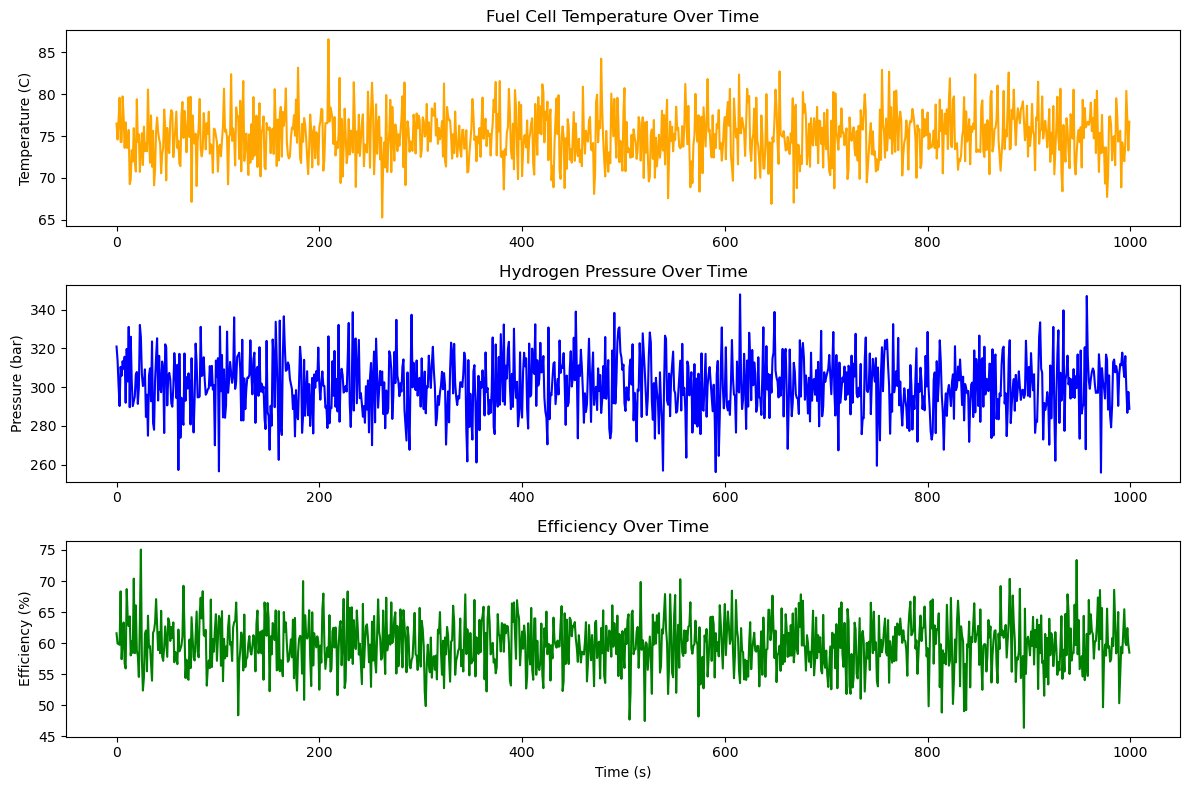

In [5]:
plt.figure(figsize=(12,8))

# fuel cell temp over time
plt.subplot(3,1,1)
plt.plot(df['timestamp'], df['fuel_cell_temp'], color='orange')
plt.title("Fuel Cell Temperature Over Time")
plt.ylabel("Temperature (C)")

# hydrogen pressure over time
plt.subplot(3,1,2)
plt.plot(df['timestamp'], df['hydrogen_pressure'], color='blue')
plt.title("Hydrogen Pressure Over Time")
plt.ylabel("Pressure (bar)")

# efficiency over time
plt.subplot(3,1,3)
plt.plot(df['timestamp'], df['efficiency'], color='green')
plt.title("Efficiency Over Time")
plt.ylabel("Efficiency (%)")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

### Inject synthesized failure events

rows 200:250 --> mild failures

rows 600:650 --> severe failures

In [6]:
# initial 'failure_event' column is 0 (no failure) by default
df['failure_event'] = 0

# rows 200:235 --> mild failure
df.loc[200:250, 'hydrogen_pressure'] -= 30 # mild drop in pressure
df.loc[200:250, 'fuel_cell_temp'] += 6 # mild spike in temp
df.loc[200:250, 'efficiency'] -= 5 # small efficiency loss
df.loc[200:250, 'failure_event'] = 1

# rows 600:650 --> severe failure
df.loc[600:650, 'hydrogen_pressure'] -= 50 # severe drop in pressure
df.loc[600:650, 'fuel_cell_temp'] += 10 # severe spike in temp
df.loc[600:650, 'efficiency'] -= 8 # big efficiency loss
df.loc[600:650, 'failure_event'] = 1

### Visualizing Anomalies

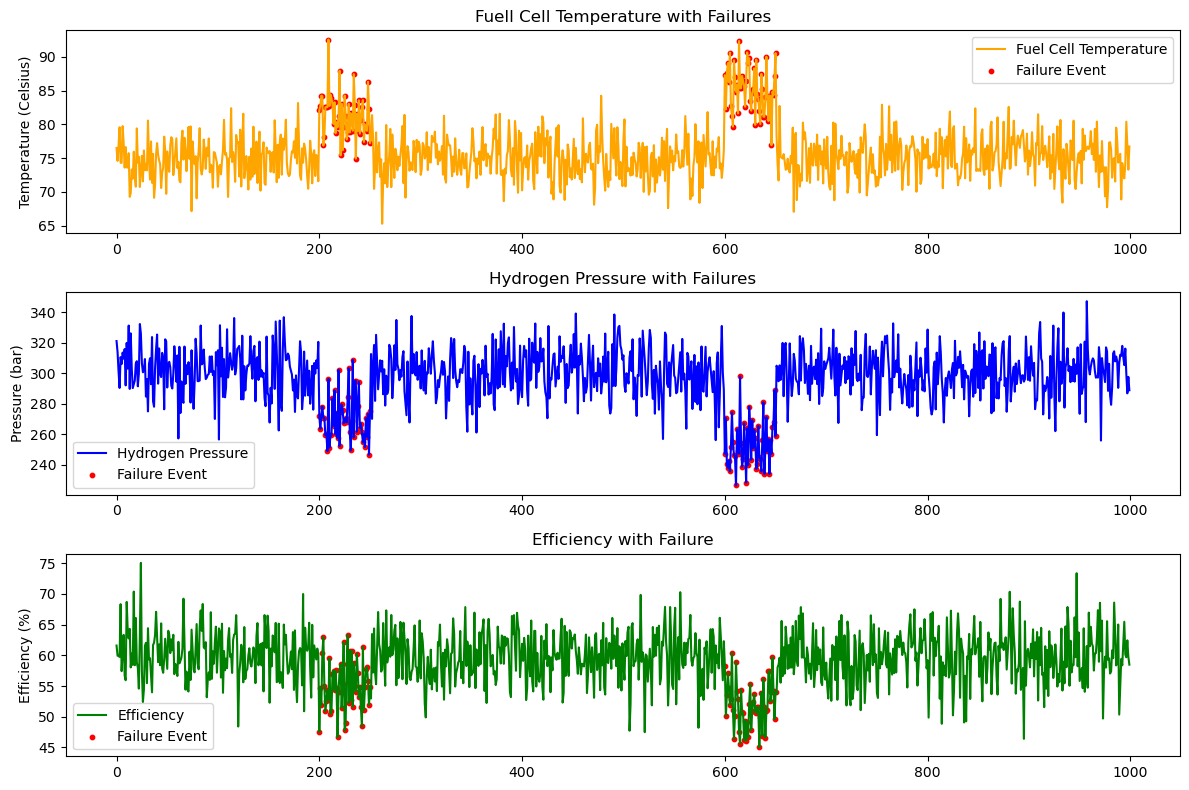

In [7]:
plt.figure(figsize=(12,8))

# fuel cell temp
plt.subplot(3,1,1)
plt.plot(df['timestamp'], df['fuel_cell_temp'], label="Fuel Cell Temperature", color='orange')
# mark failure events in red
plt.scatter(df.loc[df['failure_event'] == 1, 'timestamp'],
            df.loc[df['failure_event'] == 1, 'fuel_cell_temp'],
            color='red', label='Failure Event', s=10)
plt.legend()
plt.ylabel("Temperature (Celsius)")
plt.title("Fuell Cell Temperature with Failures")

# hydrogen pressure
plt.subplot(3,1,2)
plt.plot(df['timestamp'], df['hydrogen_pressure'], label='Hydrogen Pressure', color='blue')
# mark failure events in red
plt.scatter(df.loc[df['failure_event'] == 1, 'timestamp'],
            df.loc[df['failure_event'] == 1, 'hydrogen_pressure'],
            color='red', label='Failure Event', s=10)
plt.legend()
plt.ylabel("Pressure (bar)")
plt.title("Hydrogen Pressure with Failures")

# efficiency
plt.subplot(3,1,3)
plt.plot(df['timestamp'], df['efficiency'], label="Efficiency", color='green')
# mark failure events in red
plt.scatter(df.loc[df['failure_event'] == 1, 'timestamp'],
            df.loc[df['failure_event'] == 1, 'efficiency'],
            color='red', label='Failure Event', s=10)
plt.legend()
plt.ylabel("Efficiency (%)")
plt.title("Efficiency with Failure")

plt.tight_layout()
plt.show
plt.savefig("failure_overtime.png")

### Building classification model

In [8]:
# predicting failure_event

# features
X = df[['fuel_cell_temp', 'hydrogen_pressure', 'motor_torque', 'battery_voltage', 'ambient_temp', 'efficiency']]

# target
y = df['failure_event']

In [9]:
# 80% --> training data
# 20% --> testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Confusion matrices

True negative ----------- False positive

False negative ---------- True positive

#### Classification reports

precision: how many were true failure captured by model

recall: how many failures (out of all) were caught by the model

F1 score: balance between precision and recall

accuracy: overall, how often model was correct 

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# predict test data
y_pred = model.predict(X_test)

# confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Confusion Matrix:
[[176   1]
 [  3  20]]

Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.994     0.989       177
           1      0.952     0.870     0.909        23

    accuracy                          0.980       200
   macro avg      0.968     0.932     0.949       200
weighted avg      0.980     0.980     0.980       200



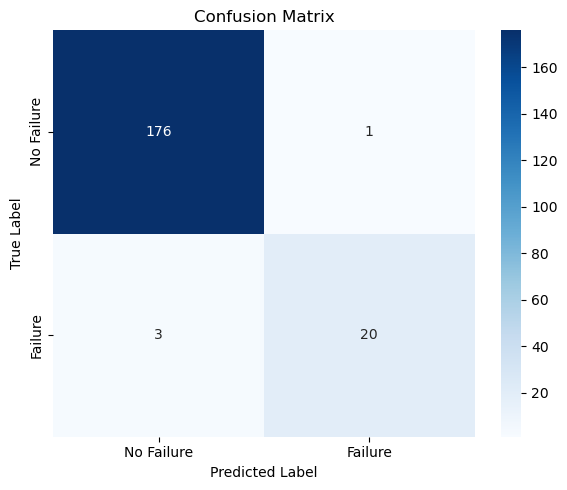

<Figure size 640x480 with 0 Axes>

In [12]:
cm = confusion_matrix(y_test, y_pred)

# labels for heatmap
labels = ['No Failure', 'Failure']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix.png")

### Plot feature importances


Features that are important (from most to least) to the model when predicting failure events

C:\Users\minod\AppData\Local\Temp\ipykernel_17800\1125843123.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


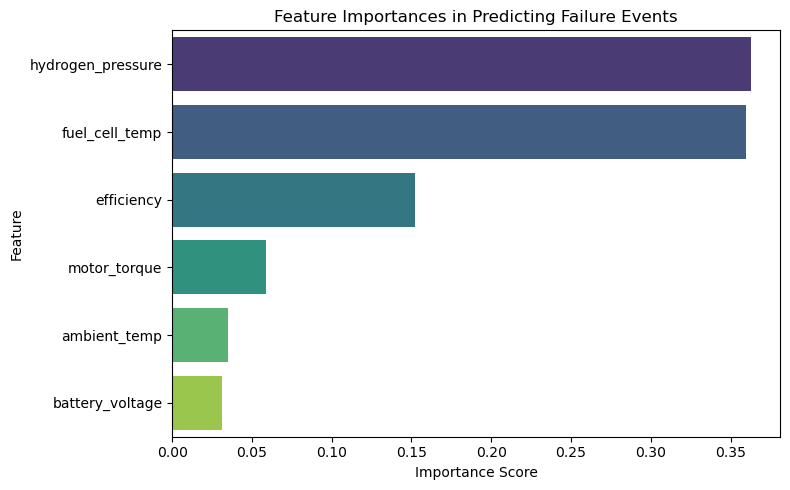

<Figure size 640x480 with 0 Axes>

In [13]:
# get feature importances
importances = model.feature_importances_
features = X_train.columns

# dataframe to plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances in Predicting Failure Events")
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.savefig("feature_importance.png")

### Plot ROC Curve

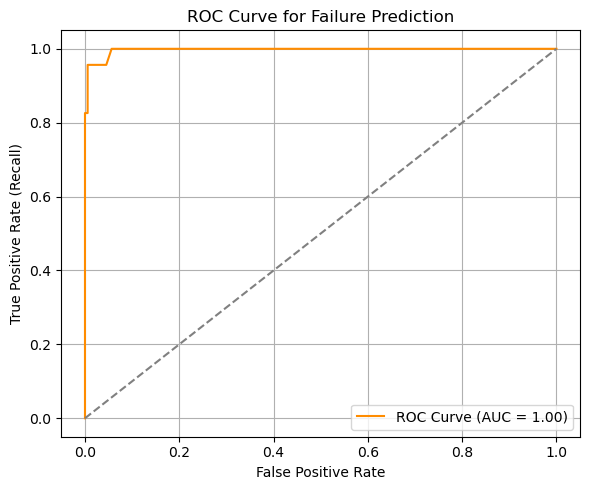

<Figure size 640x480 with 0 Axes>

In [14]:
from sklearn.metrics import roc_curve, auc

# model probability predictions
y_probs = model.predict_proba(X_test)[:, 1] # prob of class 1

# ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0,1], [0,1], linestyle = '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for Failure Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("roc_curve.png")

### Tuning the Model

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced', {0:1, 1:3}]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state = 42),
    param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': [None, 'balanced', ...], 'max_depth': [None, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


### Retraining model with best params

In [16]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# predict
y_pred = best_model.predict(X_test)

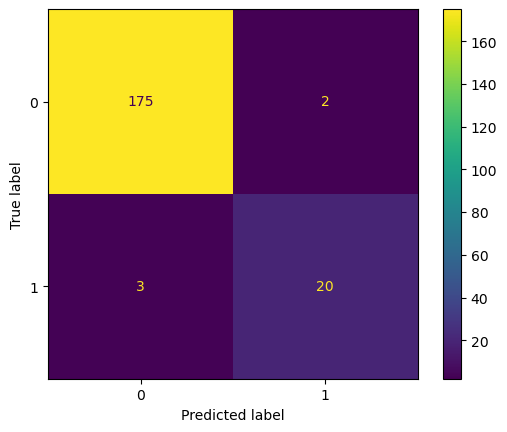

In [17]:
# confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

cm_best = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp.plot()

In [18]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       177
           1       0.91      0.87      0.89        23

    accuracy                           0.97       200
   macro avg       0.95      0.93      0.94       200
weighted avg       0.97      0.97      0.97       200



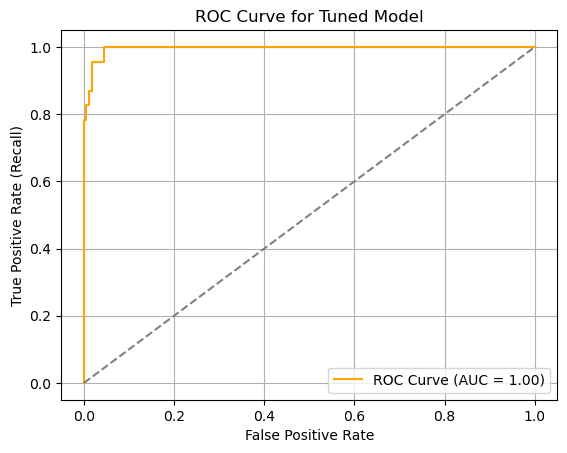

In [19]:
# ROC Curve

# probabilities for class 1
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='orange')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for Tuned Model')
plt.legend()
plt.grid(True)
plt.show()